# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [1]:
import os
import copy
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import warnings

from CogniPredictAD.classification import ADNIClassifier
from CogniPredictAD.visualization import Visualizer
from imblearn.pipeline import Pipeline
from sklearn.tree import export_text, export_graphviz, plot_tree

pd.set_option("display.max_rows", 116)
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_info_columns", 40) 

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message=".*The `disp` and `iprint` options of the L-BFGS-B solver are deprecated.*",
    category=DeprecationWarning
)

train = pd.read_csv("../data/train.csv")
sampled = pd.read_csv("../data/sampled.csv")

display(train)

,DX,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,AD,80,1,14,0,21,6.5,42,0,19,13,300,15,1,100.0000,-20.06920,3.14286,3.000000,3.000000,3.200000,2.500000,2.75,4.000000,3.444440,2.666670,3.000000,3.666670,3.75,1.042620,0.630939,0.061115,0.003517,0.000970,0.009514,0.011188,0.039862,0.680575
1,LMCI,82,1,20,0,24,1.5,20,2,4,20,155,29,0,83.3333,-10.20060,2.10000,1.780554,1.274284,1.373334,1.699998,1.65,2.950000,2.530556,2.014286,1.756666,2.316666,2.75,1.080580,0.421770,0.041719,0.003360,0.001276,0.008863,0.010643,0.049299,0.640478
2,LMCI,71,1,19,0,26,1.0,8,2,2,25,106,51,2,-18.1818,-5.90200,2.75000,2.555560,2.285710,3.200000,3.833330,3.50,1.510714,1.266666,1.438096,1.760000,1.680000,1.85,1.414550,0.182691,0.016757,0.005090,0.002786,0.012161,0.014206,0.025251,0.630110
3,CN,75,0,20,0,30,0.0,6,19,0,26,58,61,7,20.0000,3.19941,1.75000,1.333330,1.000000,1.000000,1.166670,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.118820,0.263255,0.024724,0.004908,0.002758,0.012983,0.013293,0.044823,0.677111
4,CN,81,0,19,0,29,0.0,8,11,0,29,54,54,7,28.5714,-1.16303,1.87500,1.555560,1.000000,1.000000,1.333330,1.75,1.375000,1.111110,1.000000,1.200000,1.166670,1.75,1.270141,0.197315,0.018091,0.004700,0.002912,0.013675,0.016983,0.036393,0.726675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,LMCI,64,0,14,2,27,2.0,22,0,9,22,62,31,1,100.0000,-10.37820,2.97500,1.930556,1.585714,1.400000,1.416668,1.95,3.025000,1.955554,1.671428,1.600000,1.866666,2.35,1.096238,0.709354,0.067789,0.003776,0.001849,0.010658,0.011583,0.019025,0.659038
1930,LMCI,82,1,18,0,28,1.5,23,5,1,25,79,33,1,42.8571,-9.18102,2.12500,1.125000,1.166670,2.000000,2.500000,2.00,2.625000,1.625000,1.166670,1.400000,1.833330,2.00,1.068610,0.263624,0.025132,0.003199,0.001527,0.012497,0.014003,0.030409,0.648833
1931,LMCI,76,1,12,0,25,1.0,16,3,1,22,300,27,2,16.6667,-9.94141,1.60000,1.533332,1.219048,1.040000,1.133334,1.45,2.100000,1.322222,1.657144,1.400000,1.366666,2.05,1.130734,0.175266,0.015387,0.005291,0.002843,0.009460,0.013091,0.019144,0.634472
1932,LMCI,74,1,19,1,26,2.0,27,3,8,21,102,32,1,100.0000,-13.05080,1.87500,1.333330,1.000000,1.200000,1.333330,1.00,3.125000,2.875000,1.857140,1.333330,2.250000,3.25,1.116780,0.673073,0.062445,0.002890,0.001061,0.008794,0.009382,0.040972,0.642200


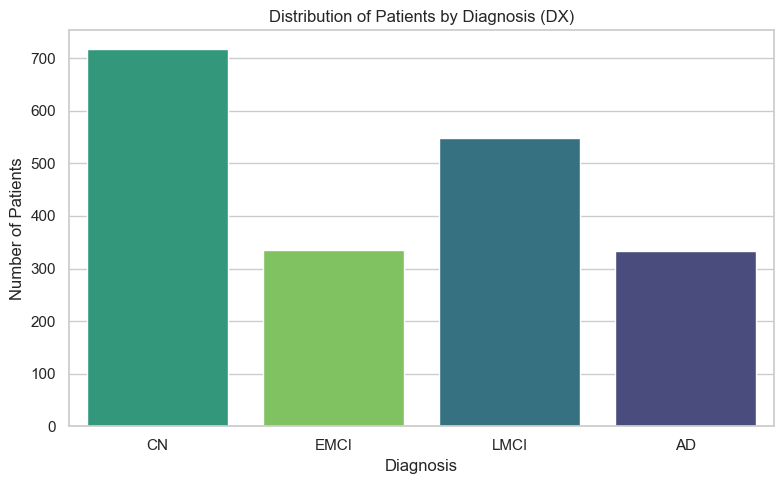

In [2]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

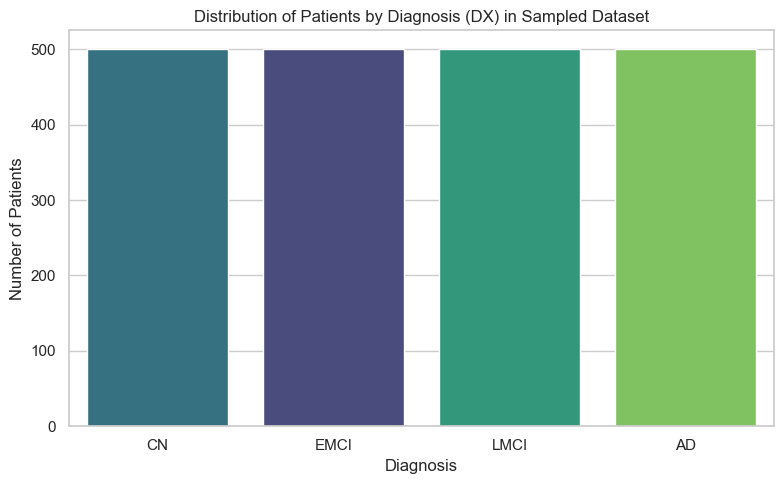

In [3]:
viz = Visualizer(sampled)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX) in Sampled Dataset"
)

In [4]:
pretrain = pd.read_csv("../data/pretrain.csv")

# Target column
y_train = pretrain['DX']

# All other columns as features
X_train = pretrain.drop(columns=['DX'])

## Explainability Function for Decision Tree

In [5]:
def save_xai_models(X_train, models_dir="../results/all_models"):
    """
    Load Decision Tree models from `models_dir` (even if inside Pipelines)
    and save XAI outputs (rules and tree images) as TXT and PDF.
    Only models whose filenames start with "Decision_Tree" are processed.
    """
    try:
        # Create output directories for tree PDFs and rule texts.
        trees_dir = os.path.join(models_dir, "trees")
        rules_dir = os.path.join(models_dir, "rules")
        os.makedirs(trees_dir, exist_ok=True)
        os.makedirs(rules_dir, exist_ok=True)

        feature_names = list(X_train.columns) if hasattr(X_train, "columns") else [f"f{i}" for i in range(X_train.shape[1])]

        # Validate models_dir exists before attempting to read.
        if not os.path.isdir(models_dir):
            raise FileNotFoundError(f"models_dir not found: {models_dir}")

        # Collect all pickled Decision Tree models in the directory.
        models = []
        # Only files that start with "Decision_Tree" and end with ".pkl" are considered.
        for fname in os.listdir(models_dir):
            if fname.endswith(".pkl") and fname.startswith("Decision_Tree"):
                with open(os.path.join(models_dir, fname), "rb") as f:
                    model = pickle.load(f)
                models.append((os.path.splitext(fname)[0], model))
        print(f"Found {len(models)} Decision_Tree models:", [n for n, _ in models])

        desired_order = ["CN", "EMCI", "LMCI", "AD"] # from least to most severe
        
        # Process each found model
        for model_name, model in models:
            tree_model = None
            if isinstance(model, Pipeline):
                tree_model = model.named_steps.get('clf', None) or next(
                    (s for s in model.named_steps.values() if hasattr(s, "tree_")), None
                )
                tree_model = tree_model or model
            else:
                tree_model = model

            if not hasattr(tree_model, "tree_"):
                raise ValueError(f"{model_name} is not a DecisionTree model.")
            
            # Prepare class reorder mapping
            orig_classes = list(getattr(tree_model, "classes_", [])) # the class labels as stored in the model
            # classes ordered with desired_order first (if present), then any remaining classes
            display_classes = [c for c in desired_order if c in orig_classes] + [c for c in orig_classes if c not in desired_order]
            idx_map = [orig_classes.index(c) for c in display_classes]

            # Work on a deep copy of the tree to avoid mutating the original object in memory.
            tree_copy = copy.deepcopy(tree_model)

            # Reorder values along class axis
            try:
                tree_copy.tree_.value[:] = tree_copy.tree_.value[:, :, idx_map]
            except Exception:
                pass
            # Update classifier metadata to match the new ordering.
            tree_copy.classes_ = np.array(display_classes)
            tree_copy.n_classes_ = len(display_classes)

            # Adjust leaf nodes to pick worst class if tied
            for i in range(tree_copy.tree_.node_count):
                # Detect leaf nodes by both children being -1.
                if tree_copy.tree_.children_left[i] == tree_copy.tree_.children_right[i] == -1:  # leaf node
                    vals = tree_copy.tree_.value[i, 0]  # shape: (n_classes,)
                    max_val = vals.max()
                    # Find which display classes are tied at the maximum value.
                    tied_classes = [display_classes[j] for j, v in enumerate(vals) if v == max_val]
                    if len(tied_classes) > 1:
                        # Pick the class with highest severity
                        worst_class = max(tied_classes, key=lambda c: desired_order.index(c))
                        tree_copy.tree_.value[i, 0, :] = 0
                        tree_copy.tree_.value[i, 0, display_classes.index(worst_class)] = max_val

            # Export textual rules
            rules_text = export_text(tree_copy, feature_names=feature_names)
            rules_text_ifthen = []
            for line in rules_text.splitlines():
                # Compute indentation level by leading spaces; export_text uses 4 spaces per indent.
                stripped = line.lstrip()
                indent = (len(line) - len(stripped)) // 4
                if stripped.startswith("|---"):
                    # Branch lines: convert to "IF <condition>"
                    rules_text_ifthen.append("    " * indent + "IF " + stripped.replace("|---", "").strip())
                else:
                    # Leaf lines or class lines: convert "class:" to "THEN class ="
                    rules_text_ifthen.append("    " * indent + stripped.replace("class:", "THEN class ="))
            rules_text = "\n".join(rules_text_ifthen)

            with open(os.path.join(rules_dir, f"{model_name}_rules.txt"), "w", encoding="utf-8") as f:
                f.write(rules_text)

            # Export tree diagram
            class_names = [str(c) for c in getattr(tree_copy, "classes_", [])] or None
            try:
                dot_data = export_graphviz(
                    tree_copy, out_file=None, feature_names=feature_names,
                    class_names=class_names, filled=True, rounded=True,
                    special_characters=True, label='all'
                )
                graph = graphviz.Source(dot_data)
                # Render graphviz to PDF and remove intermediate files (cleanup=True).
                graph.render(os.path.join(trees_dir, f"{model_name}_tree"), format="pdf", cleanup=True)
            except Exception:
                # Fallback approach: draw with matplotlib. 
                fig, ax = plt.subplots(figsize=(16, 12))
                plot_tree(tree_copy, feature_names=feature_names, class_names=class_names,
                          filled=True, rounded=True, ax=ax, label='all')
                fig.savefig(os.path.join(trees_dir, f"{model_name}_tree.pdf"), bbox_inches="tight", dpi=600)
                plt.close(fig)

        print("XAI outputs saved.")

    except Exception as e:
        print(f"Error in save_xai_models: {e}")


## Model Creation

The **ADNIClassifier** class was designed as a support tool for training and evaluating different classification models on data derived from the ADNI dataset. Upon initialization, it allows you to choose between different sets of classifiers, which can be traditional models or explainable methods (XAI), already configured with the best hyperparameters found via grid search. The main function, `fit_evaluate_store_models`, takes the training data and, for each classifier, performs a repeated stratified outer cross-validation (5-fold by default), collects predictions and probabilities, calculates global and class-specific metrics, generates comparison plots and confusion matrices. Finally, it refits each model on the entire training set, saves it to disk, and returns two DataFrames: one with the overall metrics and one with the results by class.

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: Adaptive Boosting
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Decision Tree Sampled
Training & Evaluating: Random Forest Sampled
Training & Evaluating: Extra Trees Sampled
Training & Evaluating: Adaptive Boosting Sampled
Training & Evaluating: Multinomial Logistic Regression Sampled


,Model,F1 Score (macro),Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
3,Adaptive Boosting,0.911761,0.922234,0.915825,0.923314,0.922234,0.922524,0.985843
1,Random Forest,0.910451,0.921510,0.913468,0.922425,0.921510,0.921630,0.985134
8,Adaptive Boosting Sampled,0.909640,0.920062,0.913811,0.921292,0.920062,0.920386,0.985438
2,Extra Trees,0.908256,0.919028,0.910775,0.920043,0.919028,0.919254,0.986936
6,Random Forest Sampled,0.907462,0.918407,0.912085,0.920065,0.918407,0.918675,0.984964
7,Extra Trees Sampled,0.902686,0.913030,0.908153,0.915274,0.913030,0.913627,0.986577
0,Decision Tree,0.900712,0.913444,0.904737,0.914350,0.913444,0.913629,0.978752
5,Decision Tree Sampled,0.893143,0.907239,0.894258,0.908254,0.907239,0.907198,0.975097
4,Multinomial Logistic Regression,0.867946,0.882420,0.875589,0.885789,0.882420,0.882930,0.979365
9,Multinomial Logistic Regression Sampled,0.867244,0.881696,0.874202,0.884827,0.881696,0.882343,0.978044


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,CN,0.984295,0.961506,0.972767,3585.0
1,Decision Tree,EMCI,0.885255,0.950595,0.916762,1680.0
2,Decision Tree,LMCI,0.895069,0.881022,0.887990,2740.0
3,Decision Tree,AD,0.824835,0.825826,0.825330,1665.0
4,Random Forest,CN,0.981948,0.955927,0.968763,3585.0
5,Random Forest,EMCI,0.878654,0.948214,0.912110,1680.0
6,Random Forest,LMCI,0.904209,0.909489,0.906841,2740.0
7,Random Forest,AD,0.868405,0.840240,0.854090,1665.0
8,Extra Trees,CN,0.985027,0.954254,0.969396,3585.0
9,Extra Trees,EMCI,0.887205,0.941071,0.913345,1680.0


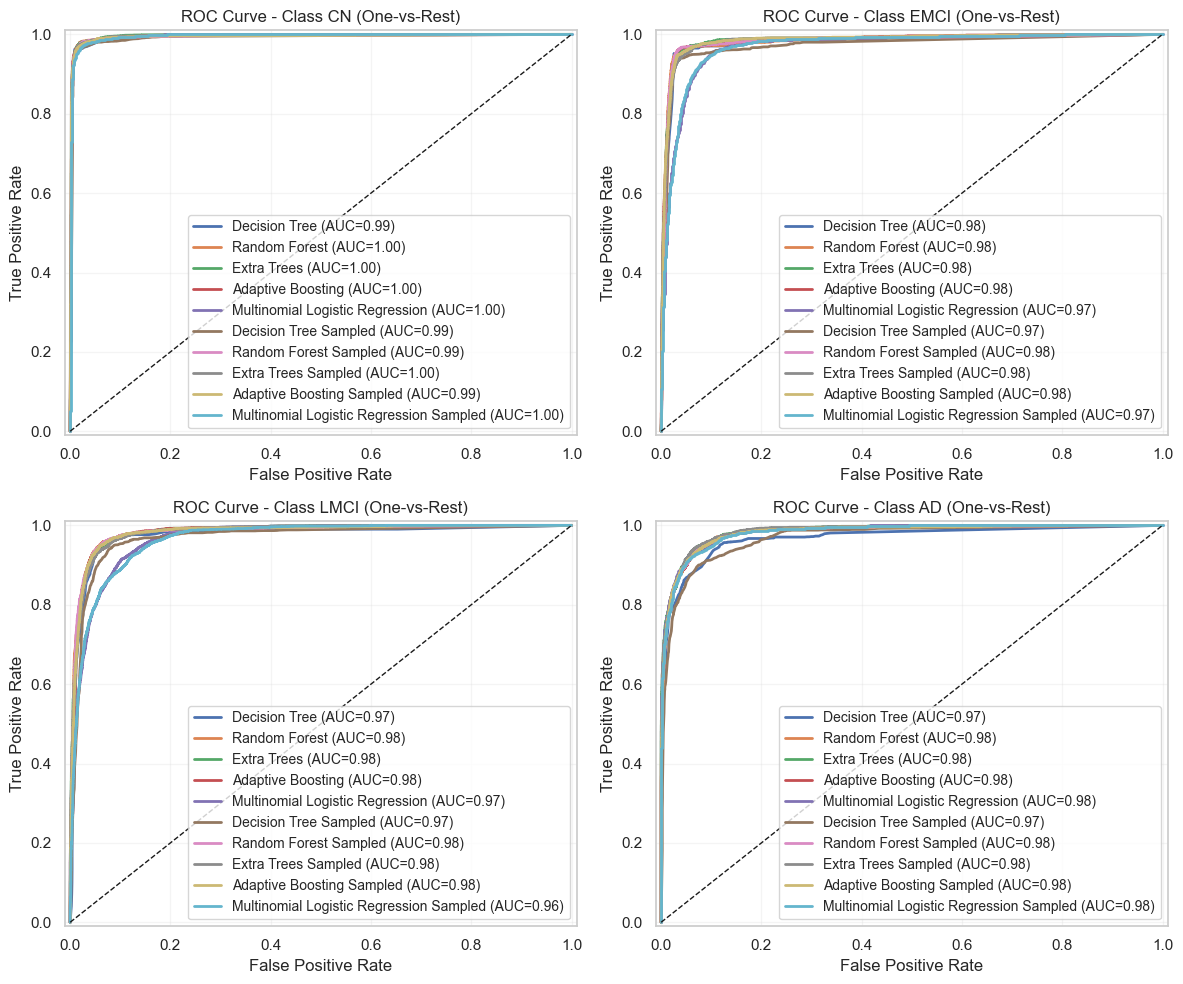

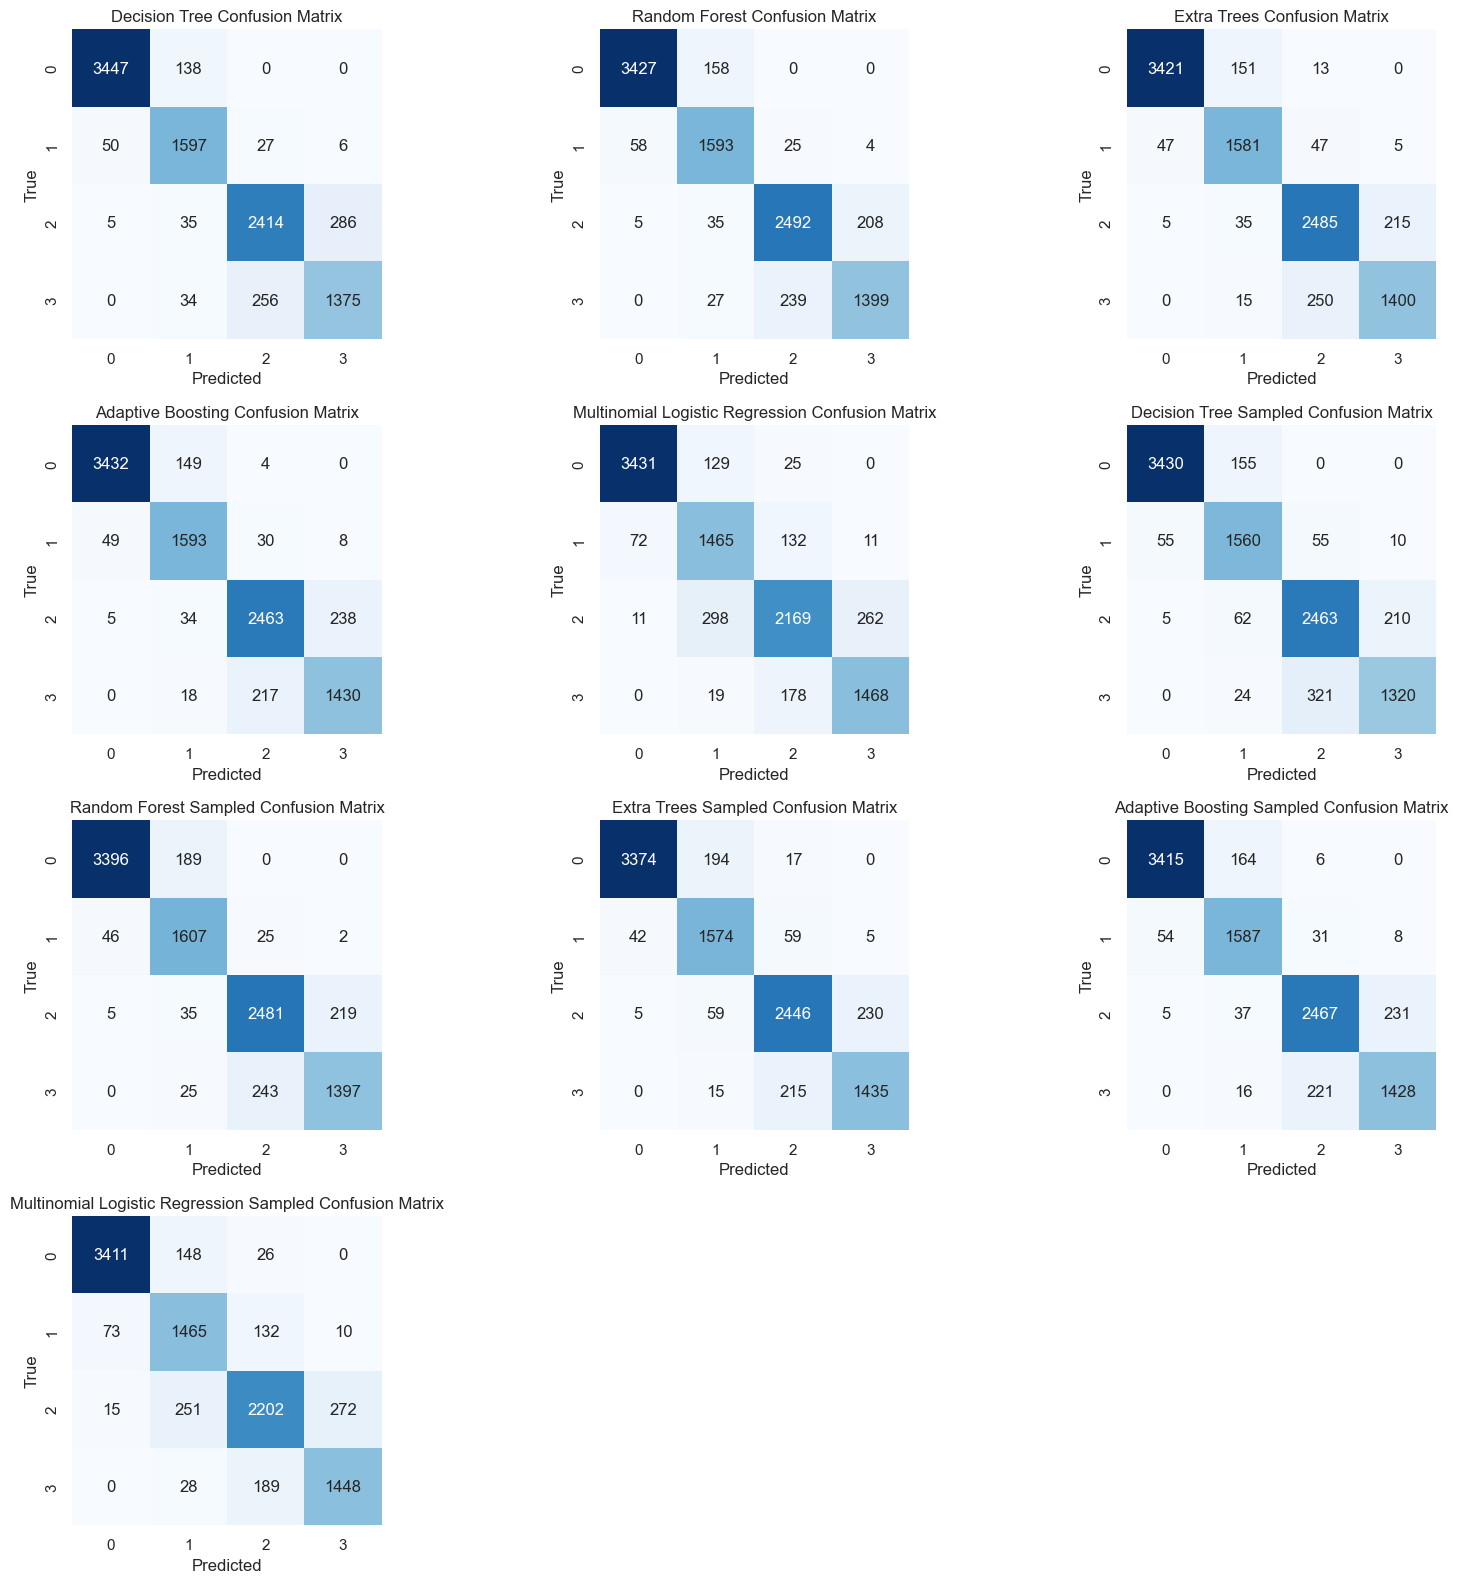

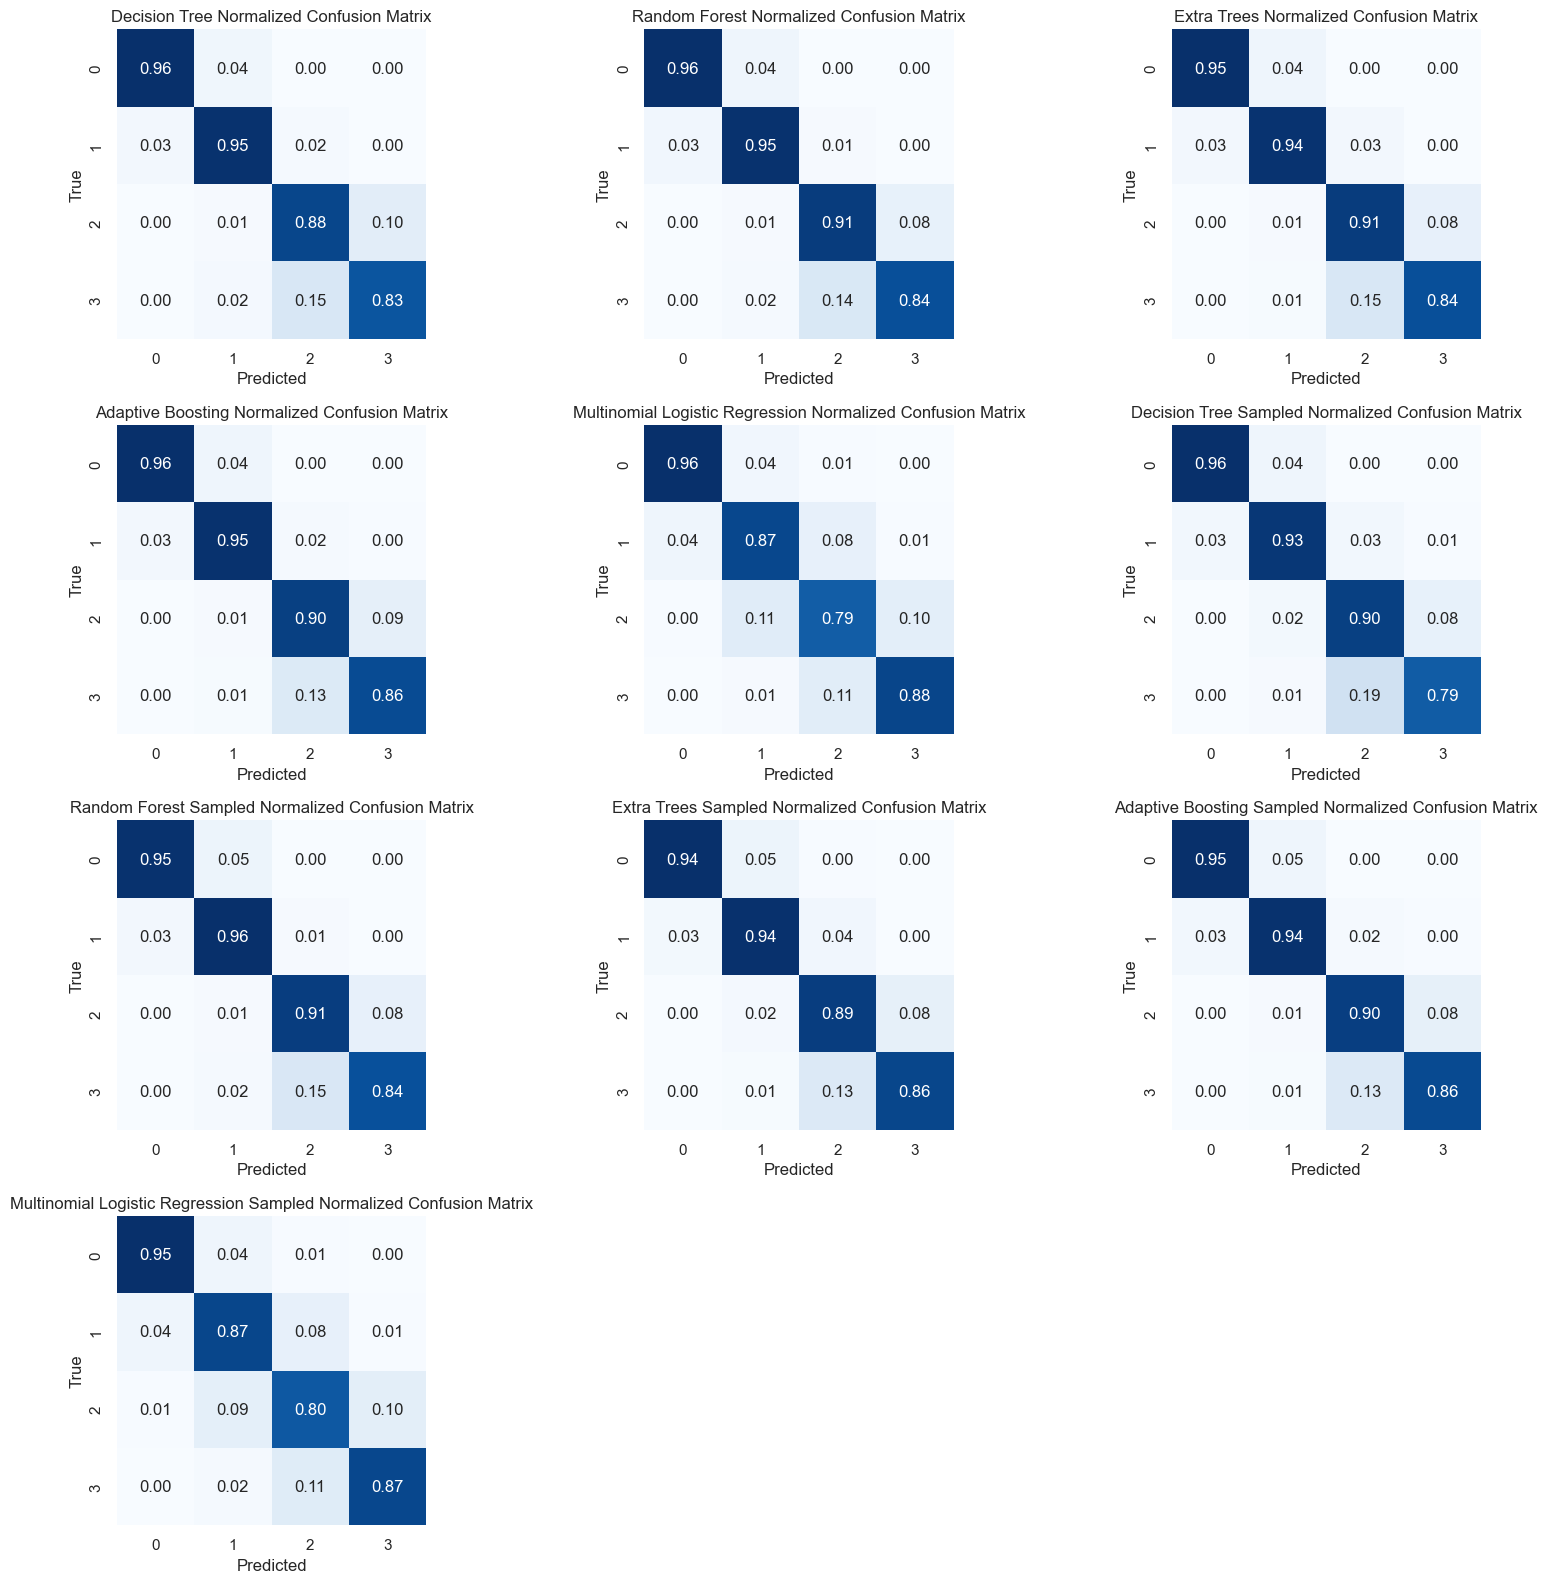

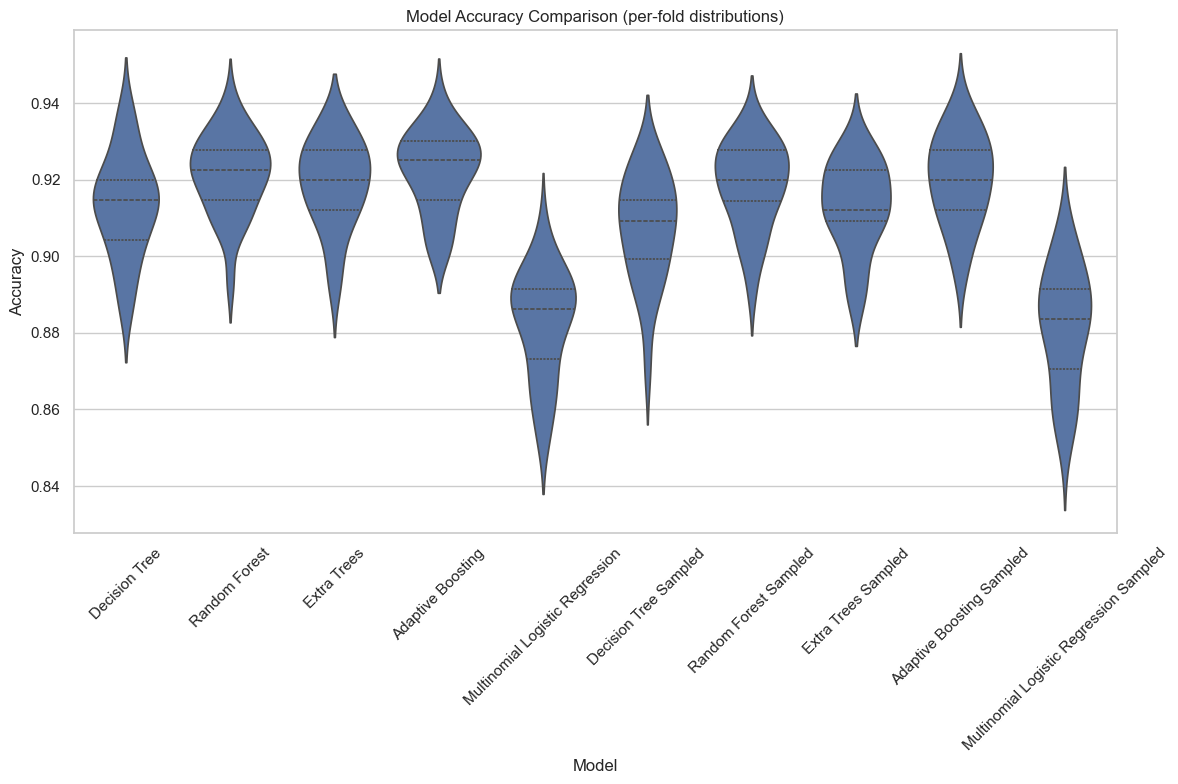

,Model A,Model B,Statistic,P-value
0,Random Forest,Multinomial Logistic Regression,0.0,5.960464e-08
1,Multinomial Logistic Regression,Random Forest Sampled,0.0,5.960464e-08
2,Multinomial Logistic Regression,Decision Tree Sampled,0.0,5.960464e-08
3,Adaptive Boosting,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
4,Adaptive Boosting,Multinomial Logistic Regression,0.0,5.960464e-08
5,Extra Trees,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
6,Extra Trees,Multinomial Logistic Regression,0.0,5.960464e-08
7,Random Forest,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
8,Random Forest Sampled,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
9,Extra Trees Sampled,Multinomial Logistic Regression Sampled,0.0,5.960464e-08


In [6]:
classifier = ADNIClassifier(classifier="Standard")
res = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models")
result_df = res["results_df"]
per_class_df = res["per_class_df"]
wilcoxon_results_df = res["wilcoxon_results_df"]

## Save Trees and Rules of Decision Trees

In [7]:
save_xai_models(X_train=train.drop(columns=['DX']), models_dir="../results/all_models")

Found 2 Decision_Tree models: ['Decision_Tree', 'Decision_Tree_Sampled']
XAI outputs saved.


## Final Results

In [8]:
display(result_df)
display(wilcoxon_results_df)

,Model,F1 Score (macro),Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
3,Adaptive Boosting,0.911761,0.922234,0.915825,0.923314,0.922234,0.922524,0.985843
1,Random Forest,0.910451,0.921510,0.913468,0.922425,0.921510,0.921630,0.985134
8,Adaptive Boosting Sampled,0.909640,0.920062,0.913811,0.921292,0.920062,0.920386,0.985438
2,Extra Trees,0.908256,0.919028,0.910775,0.920043,0.919028,0.919254,0.986936
6,Random Forest Sampled,0.907462,0.918407,0.912085,0.920065,0.918407,0.918675,0.984964
7,Extra Trees Sampled,0.902686,0.913030,0.908153,0.915274,0.913030,0.913627,0.986577
0,Decision Tree,0.900712,0.913444,0.904737,0.914350,0.913444,0.913629,0.978752
5,Decision Tree Sampled,0.893143,0.907239,0.894258,0.908254,0.907239,0.907198,0.975097
4,Multinomial Logistic Regression,0.867946,0.882420,0.875589,0.885789,0.882420,0.882930,0.979365
9,Multinomial Logistic Regression Sampled,0.867244,0.881696,0.874202,0.884827,0.881696,0.882343,0.978044


,Model A,Model B,Statistic,P-value
0,Random Forest,Multinomial Logistic Regression,0.0,5.960464e-08
1,Multinomial Logistic Regression,Random Forest Sampled,0.0,5.960464e-08
2,Multinomial Logistic Regression,Decision Tree Sampled,0.0,5.960464e-08
3,Adaptive Boosting,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
4,Adaptive Boosting,Multinomial Logistic Regression,0.0,5.960464e-08
5,Extra Trees,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
6,Extra Trees,Multinomial Logistic Regression,0.0,5.960464e-08
7,Random Forest,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
8,Random Forest Sampled,Multinomial Logistic Regression Sampled,0.0,5.960464e-08
9,Extra Trees Sampled,Multinomial Logistic Regression Sampled,0.0,5.960464e-08


**Adaptive Boosting** has the highest macro F1 value (≈ 0.9118) and the highest Accuracy/Balanced Accuracy, but the margins compared to **Random Forest** and **Extra Trees** are very small.

Oddly enough, **sampling does not produce a significant change in performance on CV folds** and therefore does not appear to bring any benefit. **Adaptive Boosting** shows that the sampled version is worse than the standard one (lower F1 macro). 

**Pairwise Wilcoxon tests** reveal that all three ensemble methods significantly outperform Multinomial Logistic Regression and Decision Tree (**p < 0.05**), while differences among the ensembles are not statistically significant, indicating that they perform equivalently on cross-validation. So, even where **p >= 0.05**, macro F1 differences are virtually negligible (very small effect). You cannot decide on the best model by relying solely on cross-validation results on the training data. 

**Because the performance margins among the top models are negligible, an independent testing set is required to make a "final" model selection and to obtain an unbiased performance estimate.**